# 1. Environment Setting

## (1) Import Modules

In [1]:
import math
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## (2) Support Function

### 1) OtsuThreshold

In [2]:
def OtsuThreshold(img):
    maxval = np.max(img)
    vectimg = np.reshape(img,[img.shape[0]*img.shape[1],])
    histData = np.uint8(np.zeros([maxval+1,1]))
    for i in vectimg:
        histData[i]=histData[i]+1
    
    total = vectimg.shape[0]
    sum_ = 0
    for i in range(256): 
        sum_ = sum_+ i*histData[i]
        
    sumB = 0
    wB = 0
    wF = 0
    varMax = (float)(0)
    threshold = 0;
    for i in range(256):
        wB = wB + histData[i]
        if(wB==0):
            continue
        wF = total-wB;
        if(wF==0):
            break
        sumB = sumB + i*histData[i]
        mB = sumB/(float)(wB)
        mF = (sum_-sumB)/(float)(wF)
        varBetween = wB*wF*(mB-mF)*(mB-mF)
        if(varBetween>varMax):
            varMax = varBetween
            threshold = i
    binaryim = np.uint8(np.zeros(img.shape))
    binaryim[img>threshold] = 255;
    return binaryim

### 2) C-means Clustering

In [3]:
# Function based C_means Clustering
def LUT2label(im,LUT):
    Imin = np.min(im)
    Imax = np.max(im)
    I =np.array(range(Imin,Imax+1))
    I = I.reshape([I.shape[0],1])
    L = np.zeros([im.shape[0],im.shape[1]],dtype=int)
    for k in range(np.max(LUT)+1):
        i = np.where(LUT==k)[0]
        i1 = int(i[0])
        
        if(i.size>1):
            i2=int(i[-1])
        else:
            i2=i1
        
        bw = np.where((im>I[i1]) & (im<I[i2]))
        for j in range(bw[0].size):
            L[bw[0][j],bw[1][j]] = k

    return L
 
# C_means Clustering    
def FastCmeans(im,c=2):
    Imin = np.min(im)
    Imax = np.max(im)
    I =np.array(range(Imin,Imax+1))
    I = I.reshape([I.shape[0],1])
    H = np.zeros([I.shape[0],1],dtype=int)
    k = im.shape[0]*im.shape[1]
    imshap =im.shape
    im = im.reshape([im.shape[0]*im.shape[1],1])
    for i in range(k):
        H[im[i]-Imin]=H[im[i]-Imin]+1 
        
    dl=(Imax-Imin)/c
    C=np.arange(Imin+dl/2,Imax,dl)
    IH = np.multiply(H,I)
    dC = float("inf")
    
    while(dC>1e-6):
        C0 =C
        D = np.ndarray([I.shape[0],0])
        for i in range(C.shape[0]):
            D = np.concatenate((D,np.subtract(I,C[i])),axis=1)
        
        D = np.abs(D)
        LUT = np.argmin(D,axis=1)
        C = np.double(C)
        for i in(range(c)):
            C[i]=np.sum(np.uint(IH[LUT==i]))/np.sum(np.uint(H[LUT==i]))
            
        dC = np.max(np.abs(np.subtract(C,C0))) 

    L =LUT2label(im,LUT)
    L = L.reshape(imshap)
    return L

## (2) Read Test Image

In [4]:
imag = cv2.imread("Test2.jpg",0)
imag = cv2.resize(imag,(imag.shape[1]/4,imag.shape[0]/4),interpolation=cv2.INTER_CUBIC)

# 2. Preprocessing

## (1) Reverse Image for Morphism

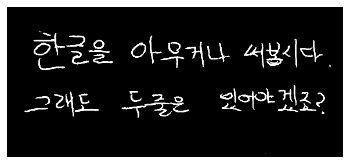

In [5]:
imag = np.uint8(np.ones(imag.shape)*255-imag)
rows,cols= imag.shape
plt.imshow(imag,cmap='gray')
plt.xticks([])
plt.yticks([])
plt.show()

## (2) Binalization

### 1) Fast-Cmeans clustering

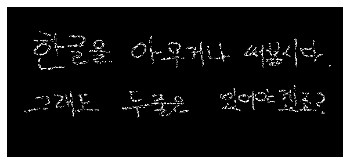

In [6]:
L = FastCmeans(imag)
onenum = np.where(L==1)[0].size
zeronum = np.where(L==0)[0].size
if(onenum>zeronum):
    L=np.ones(L.shape)- L
Cmeans = np.float32(np.multiply(L,255))

plt.imshow(Cmeans,'gray')
#plt.title('Fast-Cmeans Clustering')
plt.xticks([])
plt.yticks([])
plt.show()

### 2) Otsu-Threshold

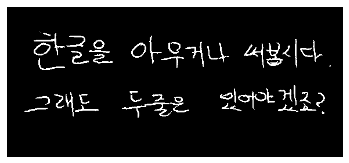

In [7]:
Otsuimag = OtsuThreshold(imag)
plt.imshow(Otsuimag,'gray')
#plt.title('OtsuThreshold')
plt.xticks([])
plt.yticks([])    
plt.show()

### 3) Adaptive Gaussian Threshold

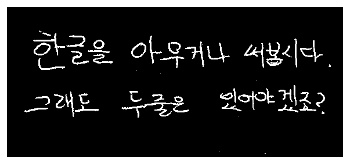

In [8]:
gaussian = cv2.adaptiveThreshold(np.uint8(np.ones(imag.shape)*255-imag),255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)
gaussian = np.ones(gaussian.shape)*255-gaussian
plt.imshow(gaussian,'gray')
#plt.title('Adaptive Gaussain Threshold')
plt.xticks([])
plt.yticks([])
plt.show()

## (3) Closing For Binary Image

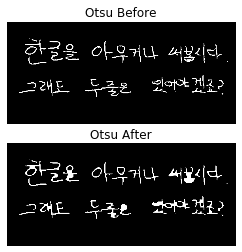

In [10]:
kernel = np.ones((5,5),np.uint8)

Otsu_closing = cv2.morphologyEx(Otsuimag,cv2.MORPH_CLOSE,kernel)


images = [Otsuimag,Otsu_closing]
titles = ['Otsu Before','Otsu After']
for i in xrange(2):
    plt.subplot(2,1,i+1)
    plt.imshow(images[i],'gray')
    plt.title(titles[i])
    plt.xticks([])
    plt.yticks([])
    
plt.show()

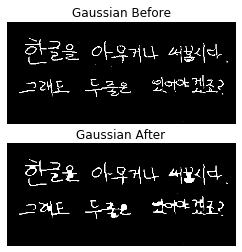

In [11]:
Gaussian_closing = cv2.morphologyEx(gaussian,cv2.MORPH_CLOSE,kernel)
images = [gaussian,Gaussian_closing]
titles = ['Gaussian Before','Gaussian After']
for i in xrange(2):
    plt.subplot(2,1,i+1)
    plt.imshow(images[i],'gray')
    plt.title(titles[i])
    plt.xticks([])
    plt.yticks([])
    
plt.show()

# 3. Text-line Segmentation

## Find strip-width

In [12]:
binaryimg = np.uint8(Gaussian_closing/255)
imagesum = np.sum(binaryimg)/(float)(rows*cols)
stripwidth = 0
if(imagesum>=0.2):
    stripwidth = 0.05*cols
elif(imagesum>0.1):
    stripwidth = 0.1*cols
else:
    stripwidth = 0.25*cols

stripwidth = int(math.ceil(stripwidth))

## Projection to y axis

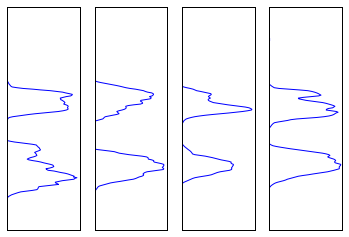

In [13]:
proj = np.zeros([rows,int(math.ceil(cols/(float)(stripwidth)))])
rangemat = range(0,cols,stripwidth)
for i in range(0,cols/stripwidth):
    proj[:,i]=np.sum(Gaussian_closing[:,rangemat[i]:rangemat[i]+stripwidth-1],axis=1)    
    
proj[:,-1] = np.uint(np.sum(Gaussian_closing[:,rangemat[i+1]:],axis=1))

proj2 = np.zeros([proj.shape[0]+10,proj.shape[1]])
proj2[5:-5,:]= proj
for i in range(rows):
    proj[i,:] = np.sum(proj2[i-5:i+5,:],axis=0)
    
proj = proj/10
x = range(proj.shape[0])
for i in range(len(rangemat)):
    plt.subplot(1,len(rangemat),i+1)
    plt.plot(proj[:,i],x)
    plt.xticks([])
    plt.yticks([])
plt.show()

## Adjust Threshold

In [14]:
alpha = 10;

threshold = np.sum(proj,axis = 0)/(alpha*rows)

## Calculate Above Boundary and Below Boundary

In [15]:
AB = np.array([])
BB = np.array([])

for j in range(rows):
    if(proj[j,0]>threshold[0] and proj[j-1,0]<=threshold[0]):
        AB = np.concatenate((AB,[j-2]))
    if(proj[j,0]>threshold[0] and proj[j+1,0]<=threshold[0]):
        BB = np.concatenate((BB,[j+2]))

BBi = np.uint8(np.zeros(BB.shape))
ABi = np.uint8(np.ones(AB.shape)*rows)
        
for i in range(1,len(rangemat)):
    BBi = np.zeros(BBi.shape)
    ABi = np.ones(ABi.shape)*rows
    A_i = 0
    B_i = 0
    for j in range(rows):
        if(proj[j,i]>threshold[i] and proj[j-1,i]<=threshold[i]):
            ABi[A_i] = j-2
            A_i += 1
        if(proj[j,i]>threshold[i] and proj[j+1,i]<=threshold[i]):
            BBi[B_i] = j+2
            B_i += 1
            
    AB = np.vstack((AB,ABi))
    BB = np.vstack((BB,BBi))


## Seperate TextLine

In [16]:
D = np.sum((np.abs(np.subtract(AB,BB))))/AB.nonzero()[0].shape[0]
#
#AB = AB.reshape([len(rangemat),AB.shape[0]/len(rangemat)])
#BB = BB.reshape([len(rangemat),BB.shape[0]/len(rangemat)])

minAB = np.uint8(np.min(AB,axis=0))
maxBB = np.uint8(np.max(BB,axis=0))
linenum = maxBB.shape[0]
rowmax = np.max(maxBB-minAB)

image_sep = np.uint8(np.zeros([linenum,rowmax,cols]))
AB = np.uint8(AB)
BB = np.uint8(BB)
for i in range(linenum):
    for j in range(len(rangemat)):
        image_sep[i,AB[j,i]-minAB[i]:BB[j,i]-minAB[i],rangemat[j]:rangemat[j]+stripwidth-1] = imag[AB[j,i]:BB[j,i],rangemat[j]:rangemat[j]+stripwidth-1]
        
#imageline1 = np.uint8(image_sep[0])
#imageline2 = np.uint8(image_sep[1])
#cv2.imshow("line1", imageline1)
#cv2.imshow("line2", imageline2)
#cv2.waitKey()


### Result

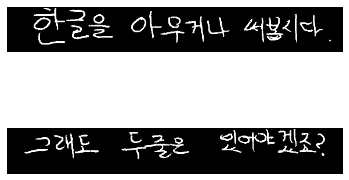

In [17]:
for i in xrange(image_sep.shape[0]):
        plt.subplot(image_sep.shape[0],1,i+1)
        plt.imshow(image_sep[i,:,:],'gray')
        plt.xticks([])
        plt.yticks([])

plt.show()

# Coarse Segmentation

## Stroke Width Transform

In [39]:
def swt(source):
    result = cv2.distanceTransform(source,cv2.cv.CV_DIST_L2,5)
    minVal,maxVal,minLoc,maxLoc=cv2.minMaxLoc(result)
    strokeradius = np.uint8(np.ceil(maxVal))
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(3,3))
    for i in xrange(strokeradius):
        result=cv2.dilate(result,kernel)
        result = np.multiply(result,source)
    
    return result

In [40]:
target = image_sep[0,:,:]

In [42]:
target = np.uint8(target/255)

In [47]:
swt_image = swt(target)

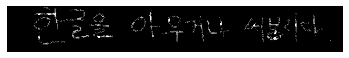

In [48]:
plt.imshow(swt_image,'gray')
plt.xticks([])
plt.yticks([])
plt.show()

In [49]:
np.max(swt_image)

2.0

In [50]:
AW = np.sum(swt_image)/np.sum(target)

In [51]:
AW

1.2214690949157945

In [53]:
x_proj = np.sum(target,axis=0)

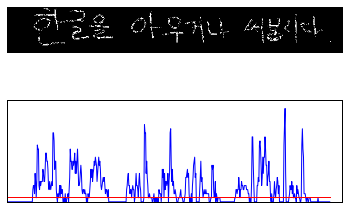

In [61]:
plt.subplot(2,1,1)
plt.imshow(target,'gray')
plt.xticks([])
plt.yticks([])
plt.subplot(2,1,2)
plt.plot(xrange(x_proj.shape[0]),x_proj)
plt.plot(xrange(x_proj.shape[0]),np.ones(x_proj.shape)*AW,'r')
plt.xticks([])
plt.yticks([])
plt.show()

In [83]:
rgbimg = np.zeros([cols,rows,3],np.uint8)

In [84]:
for i in xrange(3):
    rgbimg[:,:,i] = testimage

In [85]:
rgbimg[:,np.where(projx==0),0]= 255

<function matplotlib.pyplot.show>

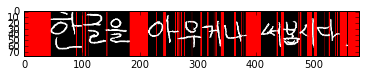

In [86]:
plt.imshow(rgbimg)
plt.show

In [ ]:
# 